# Day 06: Programming Tips, Application: Nonlinear Least Squares

---


In [1]:
import grama as gr
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 6] # Need square aspect ratio for gradients to appear normal
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## Grama vocab

![](../images/verb-classes-bw.png)


## Example: `gr.eval_nominal()`


## Linear vs Nonlinear

---


In [2]:
md_linear = (
    gr.Model("Linear, in the parameters a, n")
    >> gr.cp_function(
        fun=lambda x, a, n: a * x + n * x**3,
        var=["x", "a", "n"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        a=(-1, +1),
        n=( 1,  4),
    )
)

md_nonlinear = (
    gr.Model("Nonlinear, in the parameters a, n")
    >> gr.cp_function(
        fun=lambda x, a, n: n*(x - a)**2,
        var=["x", "a", "n"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        a=(-1, +1),
        n=( 1,  4),
    )
)

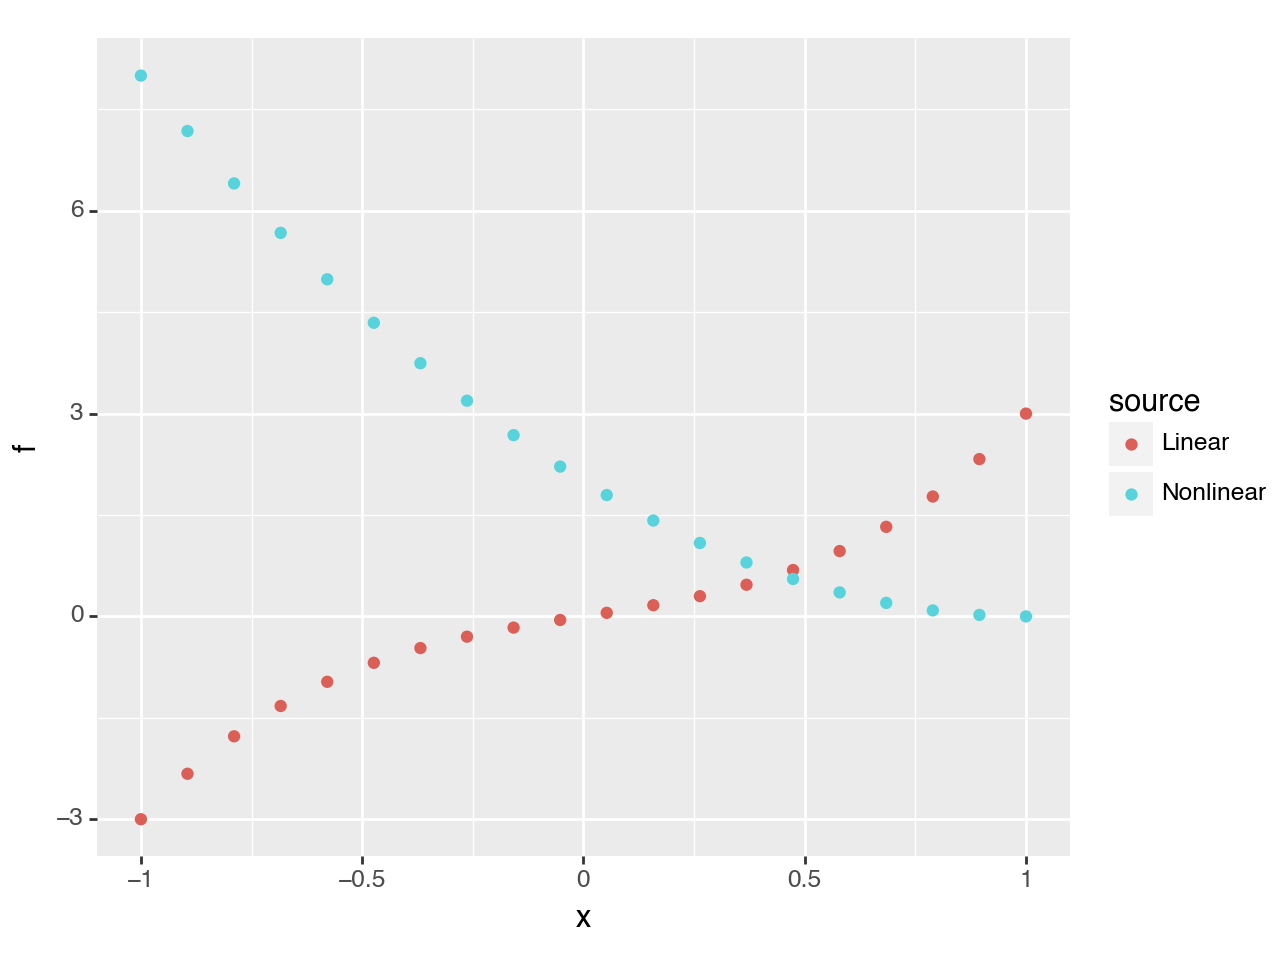

<Figure Size: (640 x 480)>

In [3]:
df_param_true = gr.df_make(a=1, n=2)

df_data = (
    gr.eval_df(
        md_linear, 
        df=gr.tran_outer(
            df_param_true,
            gr.df_make(x=gr.linspace(-1, +1, 20), source="Linear"),
        )
    )
    >> gr.tf_bind_rows(
        gr.eval_df(
            md_nonlinear, 
            df=gr.tran_outer(
                df_param_true,
                gr.df_make(x=gr.linspace(-1, +1, 20), source="Nonlinear"),
            )
        )
    )
    >> gr.tf_select("x", "f", "source")
)

(
    df_data
    >> gr.ggplot(gr.aes("x", "f", color="source"))
    + gr.geom_point()
)

In [4]:
(
    df_data
    >> gr.tf_filter(DF["source"] == "Linear")
    >> gr.ft_nls(
        md=md_linear,
    )
)

... fit_nls setting out = ['f']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'x'}
Estimated runtime: 0.0000 sec
          n    a  n_0  a_0  success  \
0  1.999998  1.0  2.5  0.0     True   

                                            message  n_iter           mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       8  1.180876e-12  


model: Linear, in the parameters a, n (Fitted)

  inputs:
    var_det:
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['x'] -> ['n', 'a']
      Linear, in the parameters a, n: ['x', 'a', 'n'] -> ['f']

In [5]:
(
    df_data
    >> gr.tf_filter(DF["source"] == "Nonlinear")
    >> gr.ft_nls(
        md=md_nonlinear,
    )
)

... fit_nls setting out = ['f']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'x'}
Estimated runtime: 0.0000 sec
          n    a  n_0  a_0  success  \
0  2.000001  1.0  2.5  0.0     True   

                                            message  n_iter           mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      12  2.786669e-13  


model: Nonlinear, in the parameters a, n (Fitted)

  inputs:
    var_det:
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['x'] -> ['n', 'a']
      Nonlinear, in the parameters a, n: ['x', 'a', 'n'] -> ['f']

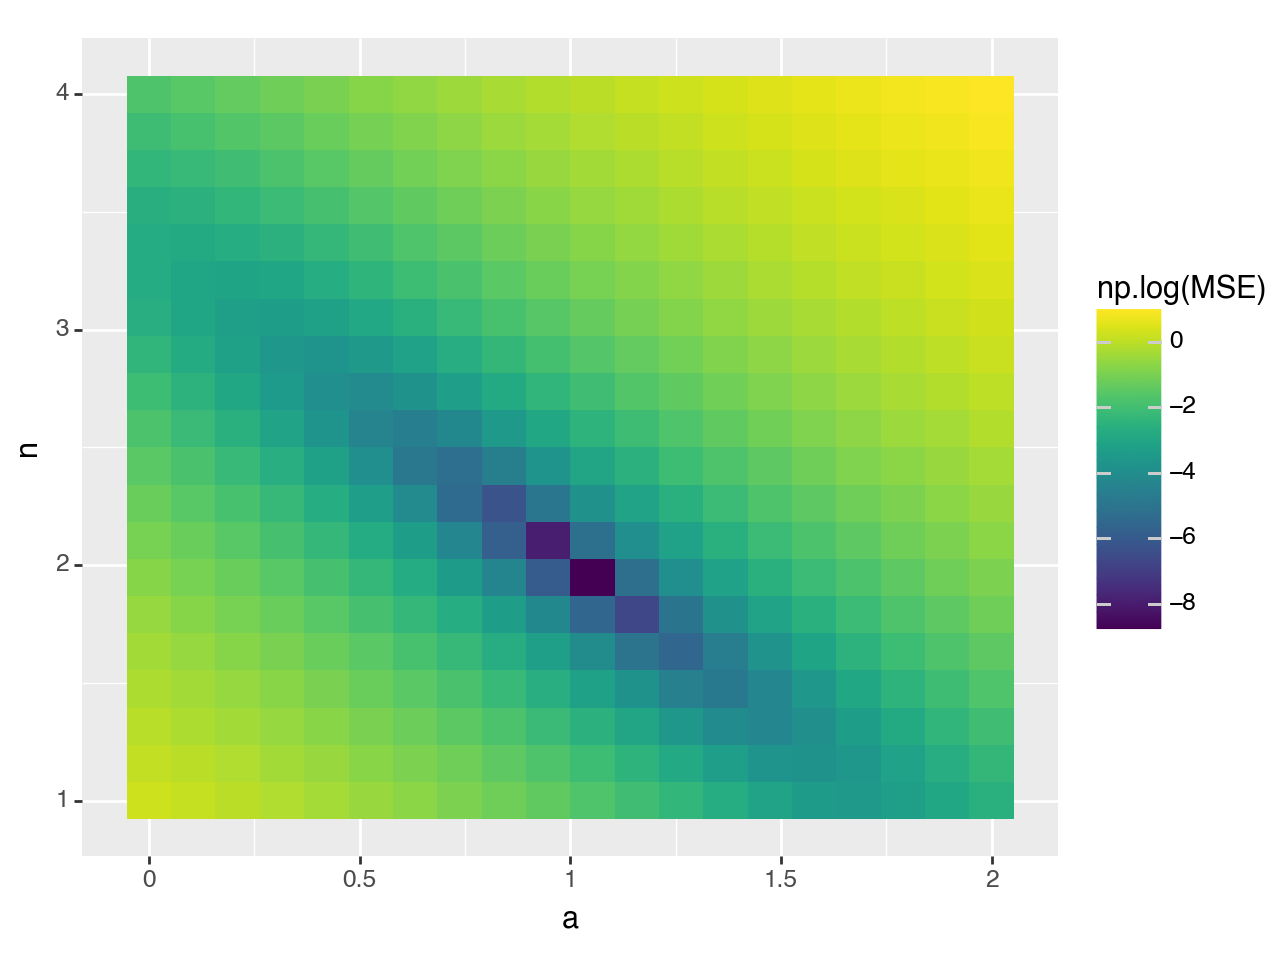

<Figure Size: (640 x 480)>

In [6]:
(
    md_linear
    >> gr.ev_df(
        df=gr.tran_outer(
            df_data 
            >> gr.tf_filter(DF["source"] == "Linear")
            >> gr.tf_rename(f_hat="f"),
            gr.df_grid(a=np.linspace(0, +2, 20), n=np.linspace(1, 4, 20))
        )
    )
    >> gr.tf_group_by(DF["a"], DF["n"])
    >> gr.tf_summarize(
        MSE=gr.mse(DF["f_hat"], DF["f"])
    )

    >> gr.ggplot(gr.aes("a", "n"))
    + gr.geom_tile(gr.aes(fill="np.log(MSE)"))
)

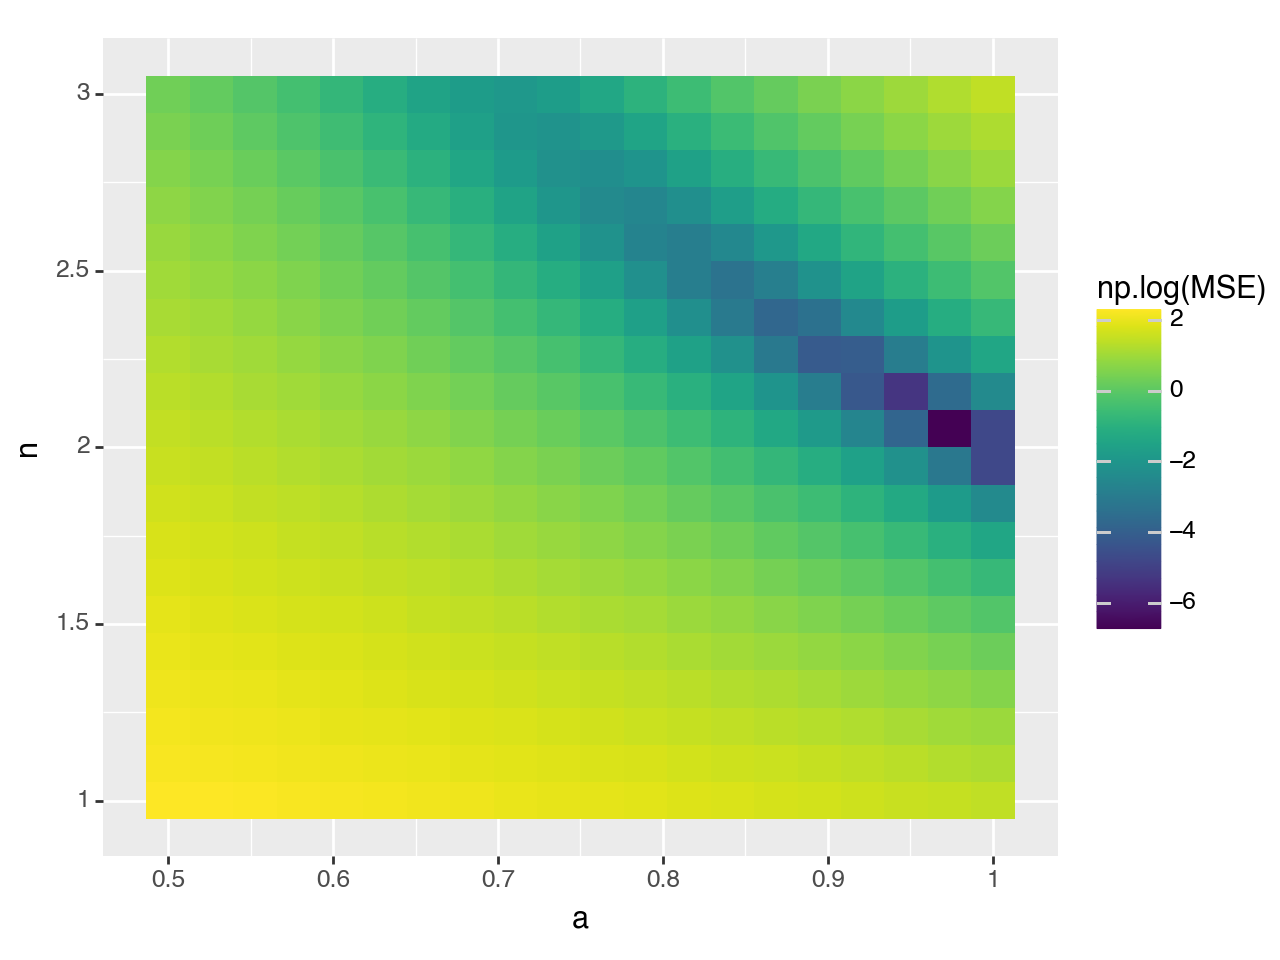

<Figure Size: (640 x 480)>

In [7]:
(
    md_nonlinear
    >> gr.ev_df(
        df=gr.tran_outer(
            df_data 
            >> gr.tf_filter(DF["source"] == "Nonlinear")
            >> gr.tf_rename(f_hat="f"),
            gr.df_grid(a=np.linspace(0.5, +1, 20), n=np.linspace(1, 3, 20))
        )
    )
    >> gr.tf_group_by(DF["a"], DF["n"])
    >> gr.tf_summarize(
        MSE=gr.mse(DF["f_hat"], DF["f"])
    )

    >> gr.ggplot(gr.aes("a", "n"))
    + gr.geom_tile(gr.aes(fill="np.log(MSE)"))
)

## Unidentifiable


In [8]:
md_unidet = (
    gr.Model("Unidentifiabl")
    >> gr.cp_function(
        fun=lambda x, a, b: (a/b) * x,
        var=["x", "a", "b"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        a=( 1, +4),
        b=( 1, +4),
    )
)

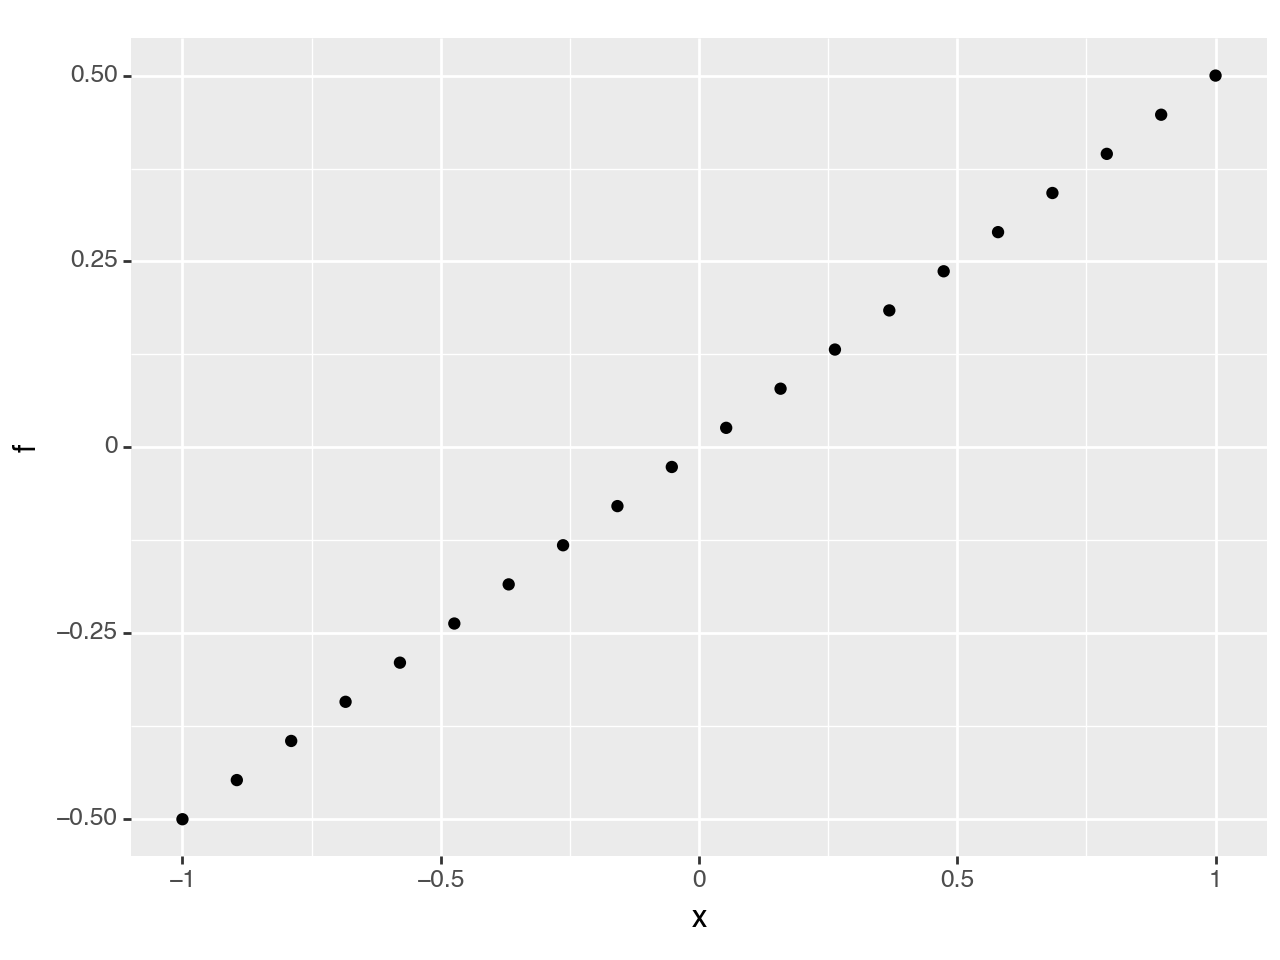

<Figure Size: (640 x 480)>

In [9]:
df_param_unidet = gr.df_make(a=1, b=2)

df_unidet = (
    gr.eval_df(
        md_unidet, 
        df=gr.tran_outer(
            df_param_unidet,
            gr.df_make(x=gr.linspace(-1, +1, 20)),
        )
    )
    >> gr.tf_select("x", "f")
)

(
    df_unidet
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_point()
)

In [10]:
(
    df_unidet
    >> gr.ft_nls(
        md=md_unidet,
    )
)

... fit_nls setting out = ['f']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'x'}
Estimated runtime: 0.0000 sec
          b        a  b_0  a_0  success  \
0  3.088265  1.54414  2.5  2.5     True   

                                            message  n_iter           mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       6  2.027450e-12  


model: Unidentifiabl (Fitted)

  inputs:
    var_det:
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['x'] -> ['b', 'a']
      Unidentifiabl: ['b', 'x', 'a'] -> ['f']

/Users/zach/opt/anaconda3/envs/pdo/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log


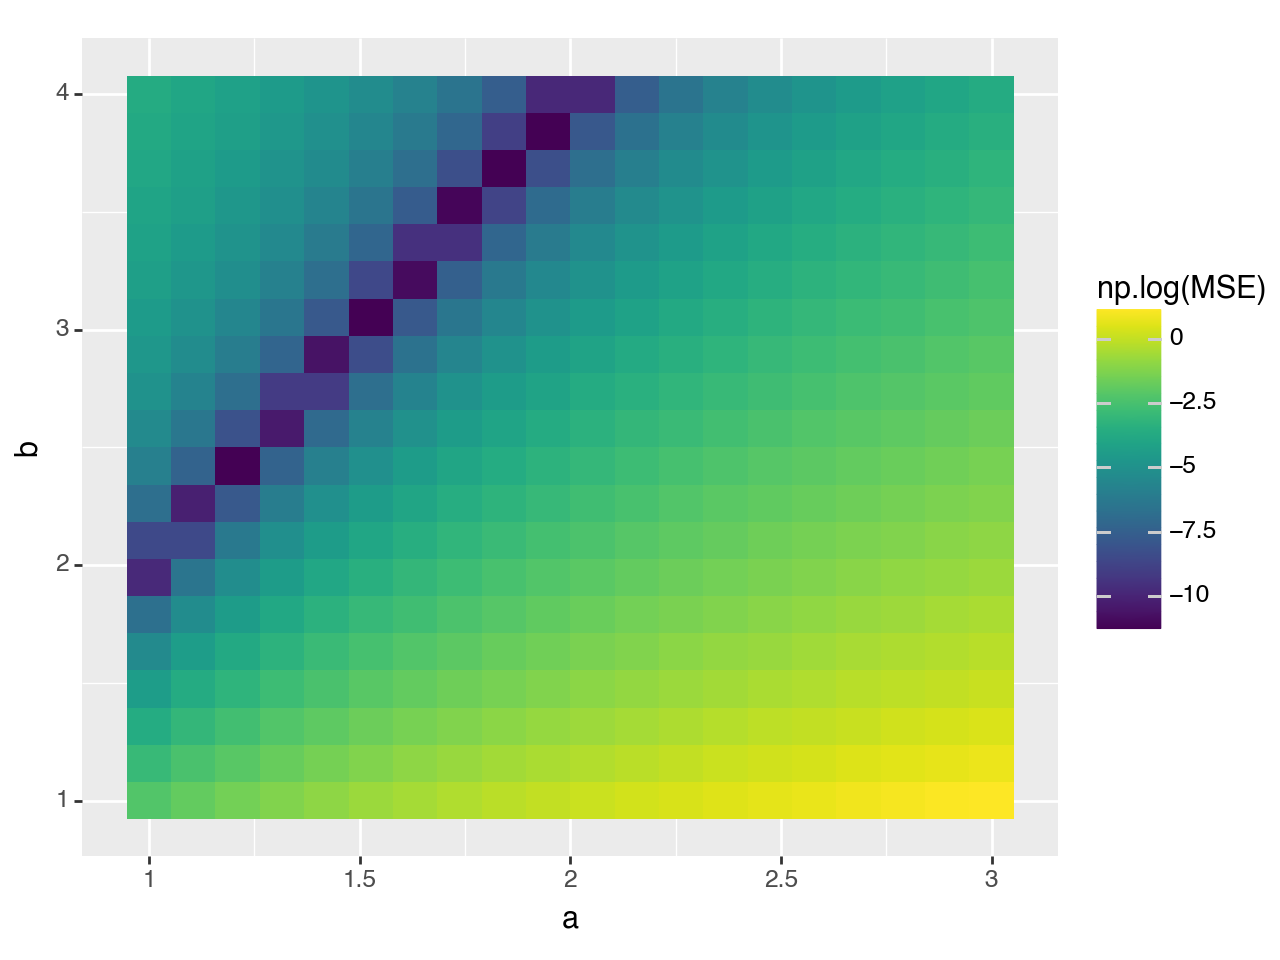

<Figure Size: (640 x 480)>

In [11]:
(
    md_unidet
    >> gr.ev_df(
        df=gr.tran_outer(
            df_unidet >> gr.tf_rename(f_hat="f"),
            gr.df_grid(a=np.linspace(1, 3, 20), b=np.linspace(1, 4, 20))
        )
    )
    >> gr.tf_group_by(DF["a"], DF["b"])
    >> gr.tf_summarize(
        MSE=gr.mse(DF["f_hat"], DF["f"])
    )

    >> gr.ggplot(gr.aes("a", "b"))
    + gr.geom_tile(gr.aes(fill="np.log(MSE)"))
)

## Baseball trajectory

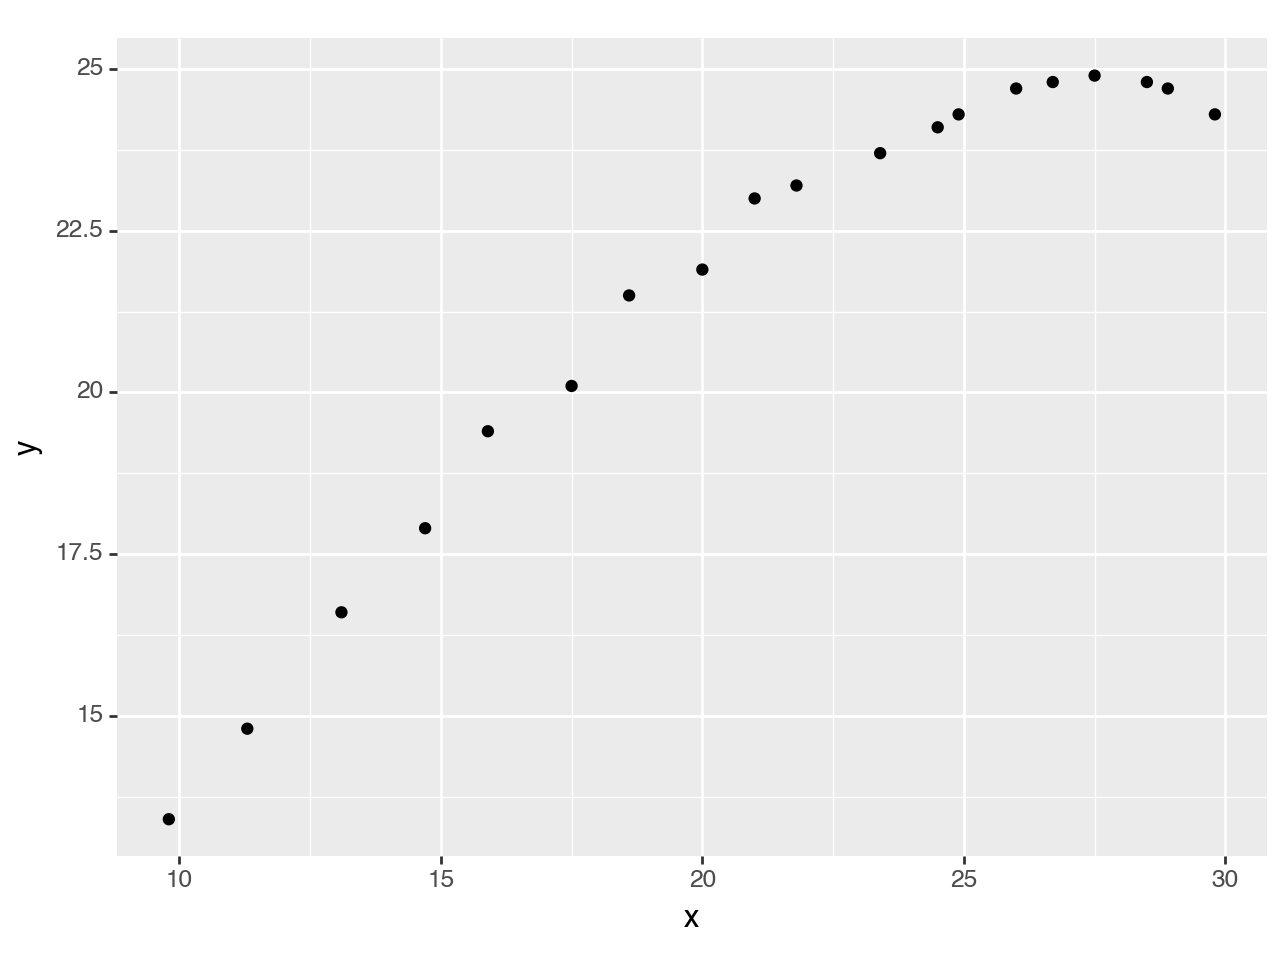

<Figure Size: (640 x 480)>

In [12]:
from grama.data import df_trajectory_windowed, df_trajectory_full
from grama.models import make_trajectory_linear

(
    df_trajectory_windowed
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_point()
)

In [13]:
md_nodrag = (
    gr.Model("Drag-free projectile motion")
    >> gr.cp_function(
        fun=lambda t, u0, v0: [u0*t, v0*t - 0.5*9.8*t**2],
        var=["t", "u0", "v0"],
        out=["x", "y"]
    )
    >> gr.cp_bounds(
        t=(0, 60),
        u0=(0.1, np.Inf),
        v0=(0.1, np.Inf),
    )
)
md_nodrag 

model: Drag-free projectile motion

  inputs:
    var_det:
      u0: [0.1, inf]
      t: [0, 60]
      v0: [0.1, inf]

    var_rand:

    copula:
      None

  functions:
      f0: ['t', 'u0', 'v0'] -> ['x', 'y']

In [14]:
md_nodrag_fitted = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_nodrag,
        n_restart=6,
    )
)

... fit_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
Estimated runtime: 0.0000 sec
Estimated runtime: 0.0000 sec
         u0         v0  u0_0  v0_0  success  \
0  13.79195  22.530599   0.1   0.1     True   
1  13.79195  22.530599   0.1   0.1     True   
2  13.79195  22.530599   0.1   0.1     True   
3  13.79195  22.530599   0.1   0.1     True   
4  13.79195  22.530599   0.1   0.1     True   
5  13.79195  22.530599   0.1   0.1     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  2.389219  
1  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  2.389219  
2  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  2.389219  
3  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  2.389219  
4  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  2.389219  
5  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  2.389219

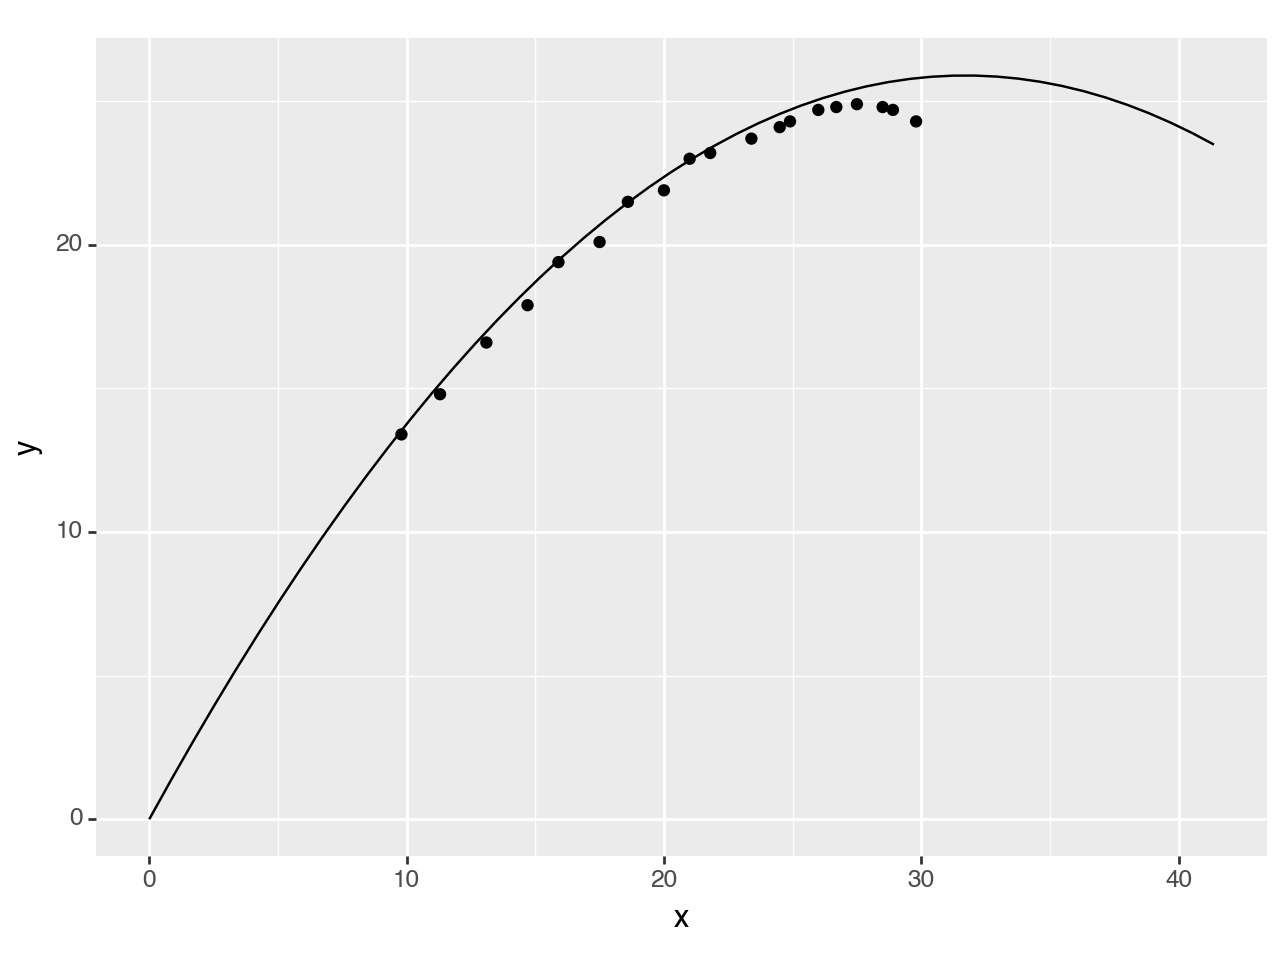

<Figure Size: (640 x 480)>

In [15]:
(
    md_nodrag_fitted
    >> gr.ev_df(df=gr.df_make(t=gr.linspace(0, 3, 50)))
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

In [16]:
# Model with linear drag
md_baseball = make_trajectory_linear()
md_baseball 

model: Trajectory Model

  inputs:
    var_det:
      u0: [0.1, inf]
      tau: [0.05, inf]
      t: [0, 600]
      v0: [0.1, inf]

    var_rand:

    copula:
      None

  functions:
      x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
      y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']

In [17]:
md_baseball_fitted1 = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_baseball,
        n_restart=6,
    )
)

... fit_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
Estimated runtime: 0.0000 sec
Estimated runtime: 0.0000 sec
           u0   tau          v0  u0_0  tau_0  v0_0  success  \
0  425.161431  0.05  447.996569   0.1   0.05   0.1     True   
1  425.161431  0.05  447.996569   0.1   0.05   0.1     True   
2  425.161431  0.05  447.996569   0.1   0.05   0.1     True   
3  425.161431  0.05  447.996569   0.1   0.05   0.1     True   
4  425.161431  0.05  447.996569   0.1   0.05   0.1     True   
5  425.161431  0.05  447.996569   0.1   0.05   0.1     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  25.49725  
1  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  25.49725  
2  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  25.49725  
3  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  25.49725  
4  CONVERGENCE: NORM_OF_PROJE

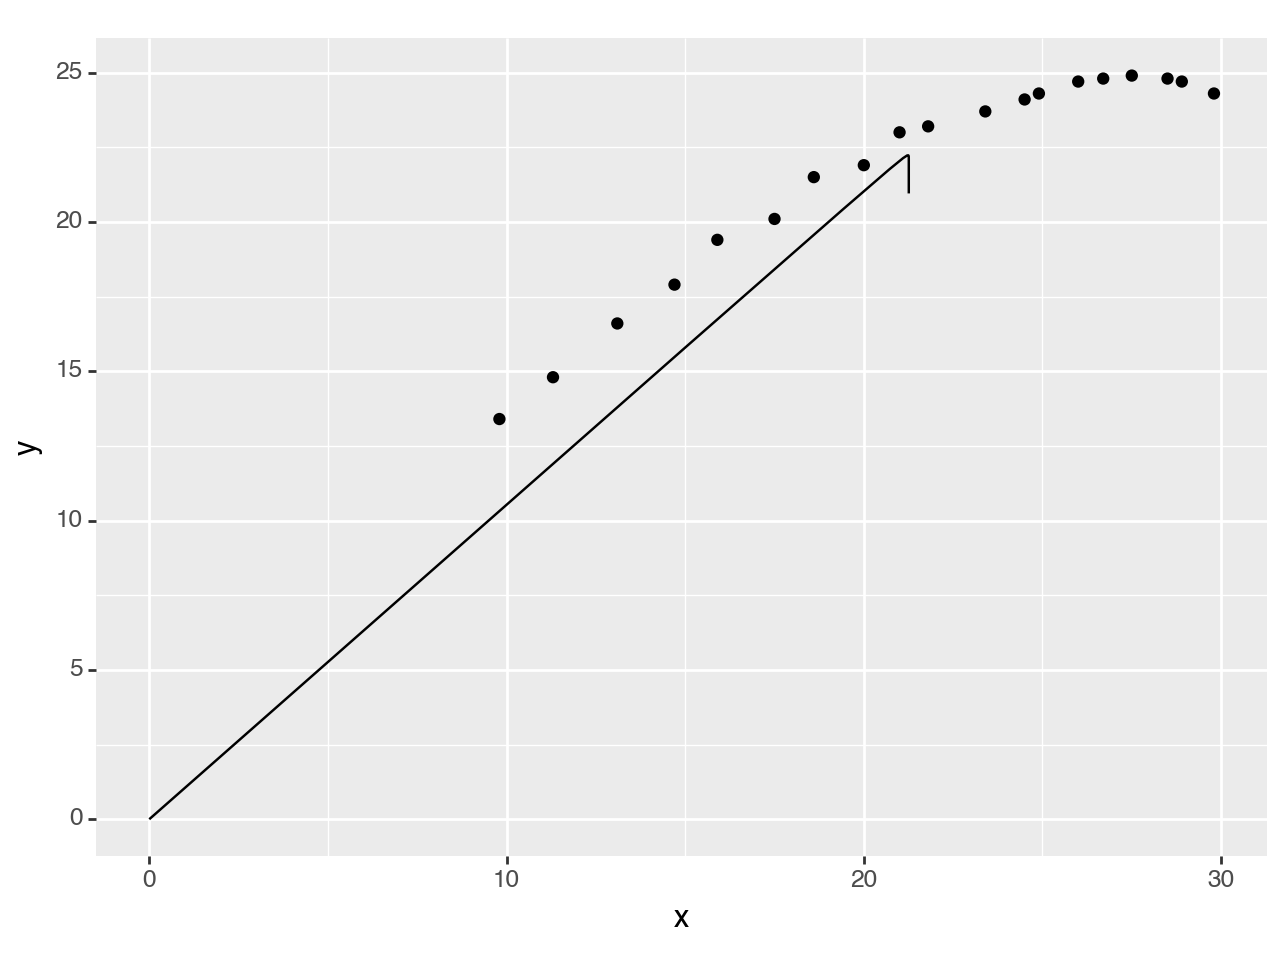

<Figure Size: (640 x 480)>

In [18]:
(
    md_baseball_fitted1
    >> gr.ev_df(df=gr.df_make(t=gr.linspace(0, 3, 50)))
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

Retry with reasonable guesses for parameters

In [19]:
md_baseball_fitted2 = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_baseball,
        df_init=gr.df_make(u0=18, v0=18, tau=10)
    )
)

... fit_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
Estimated runtime: 0.0000 sec
          u0       tau         v0  u0_0  tau_0  v0_0  success  \
0  18.792171  2.802248  28.234806    18     10    18     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      21  0.093358  


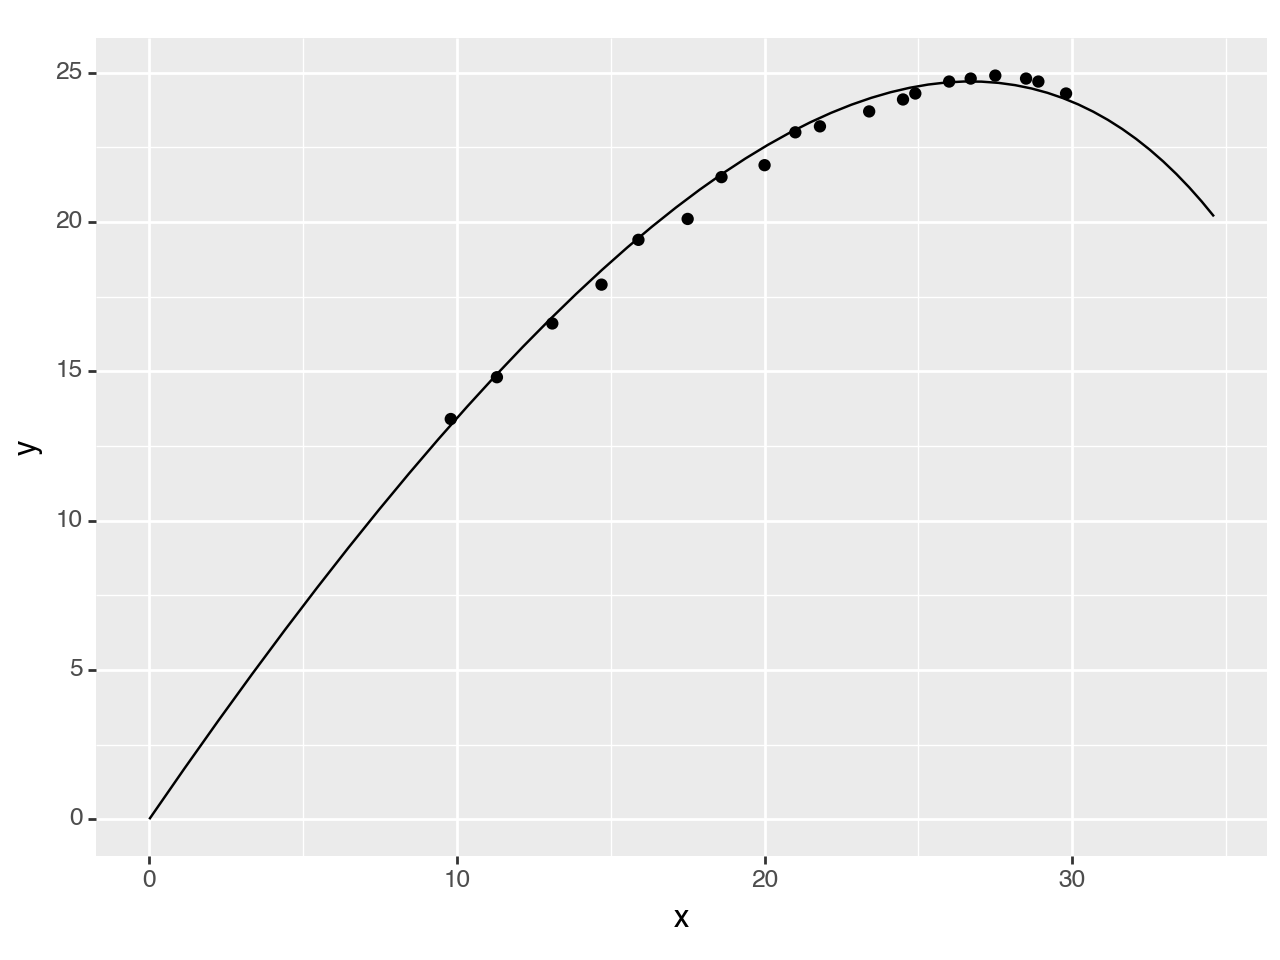

<Figure Size: (640 x 480)>

In [20]:
(
    md_baseball_fitted2
    >> gr.ev_df(df=gr.df_make(t=gr.linspace(0, 3, 50)))
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

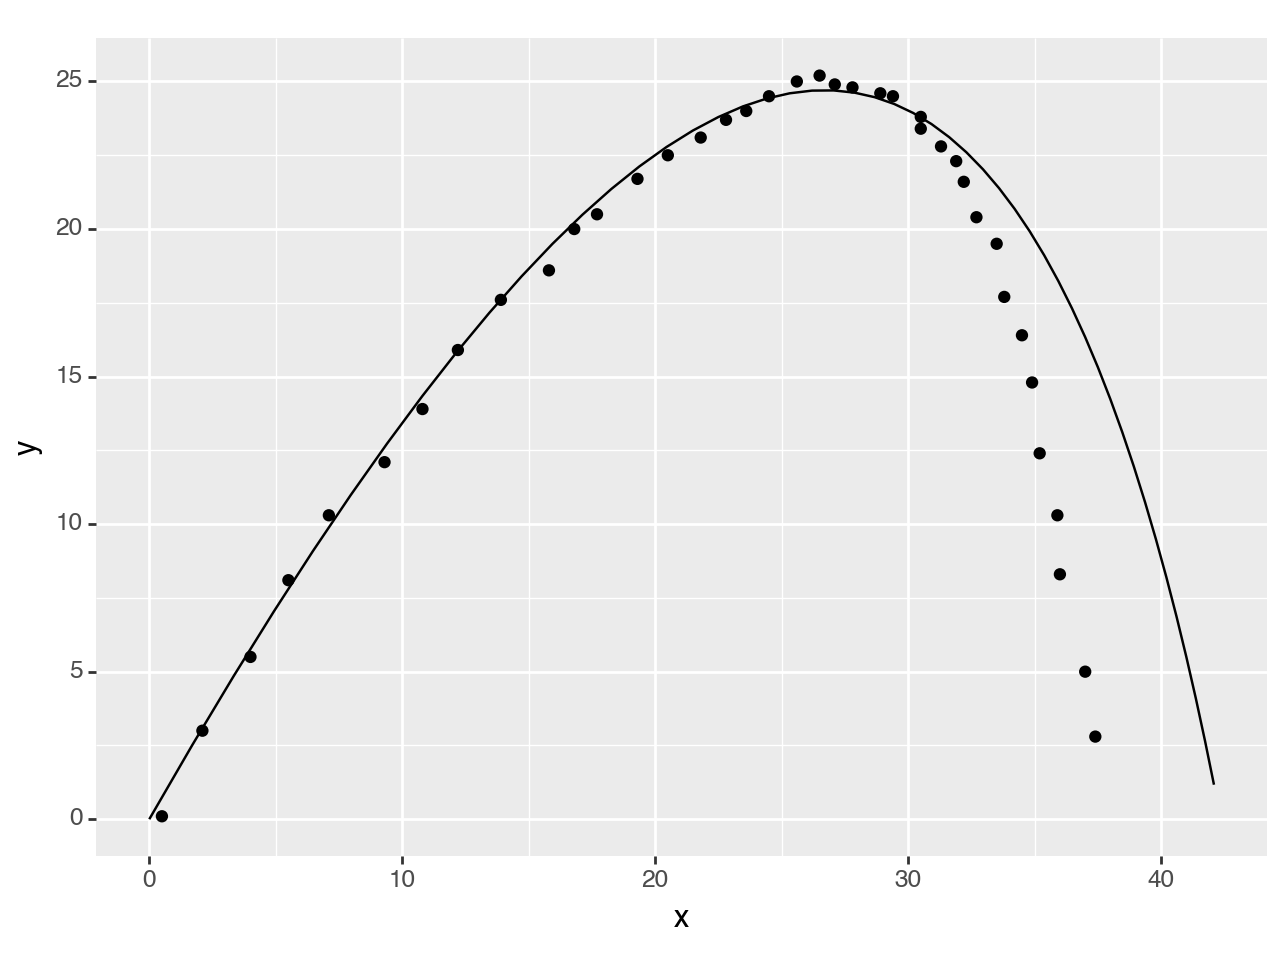

<Figure Size: (640 x 480)>

In [21]:
(
    md_baseball_fitted2
    >> gr.ev_df(df=gr.df_make(t=gr.linspace(0, 4.5, 50)))
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_full)
)